In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from codac import Interval, IntervalVector, CtcDist, Function,CtcFunction
from collections import deque
import networkx as nx
from scipy.optimize import minimize, rosen, rosen_der

c:\Users\thoma\.conda\envs\map588\lib\site-packages\numpy\core\getlimits.py:493: UserWarning: Signature b'\xcc\xcc\xcc\xbd' for <class 'numpy.float32'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
c:\Users\thoma\.conda\envs\map588\lib\site-packages\numpy\core\_machar.py:295: RuntimeWarning: overflow encountered in divide
  xmax = xmax / (xmin*beta*beta*beta)


In [2]:
f= open("graph_02.txt", mode="r")
li = []
for line in f:
    li.append(line)

In [3]:
f.close()

In [90]:
dico_constrains = {}
n= 63
dico_interval = {}
dico_interval_origin = {}
for elem in li:
    i = int(elem[6:8].split(" ")[-1])-1
    j = int(elem[16:18].split(" ")[-1])-1
    mini = float(elem[21:42])
    maxi = float(elem[45:-1])
    dico_constrains[(i,j)] = (maxi + mini)/2
    dico_interval[(i,j)] = [mini, maxi]
    dico_interval_origin[(i,j)] = [mini, maxi]
    #dico_interval[(j,i)] = [mini, maxi]

In [91]:
G = nx.Graph()
G.add_nodes_from([i for i in range(63)])
for (i,j), (mini, maxi) in dico_interval.items():
    G.add_edges_from([(i,j,{"mini":mini, "maxi":maxi})])

In [32]:
link = dict(nx.all_pairs_dijkstra(G))

In [ ]:
link[3][1]

In [15]:
len(list(link[0][0].keys()))

63

In [17]:
(0,1) in dico_interval.keys()

True

In [92]:
for i in range(n-1):
    pairs = link[i][1]
    for j in range(i+1,n):
        if ((i,j) not in dico_interval.keys()) and i!=j:
            path = pairs[j]
            maxi = 0
            for k in range(len(path)-1):
                u = path[k]
                v = path[k+1]
                maxi += G.get_edge_data(u,v)["maxi"]
            G.add_edges_from([(i,j,{"mini":0, "maxi":maxi})])
            dico_interval[(i,j)] = [0,maxi]
            


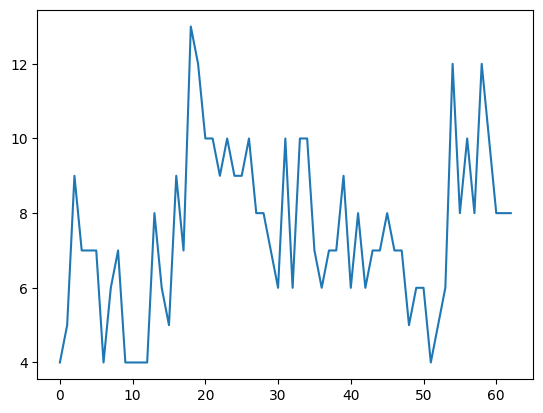

In [6]:
n_contraintes = np.zeros(63)
for (i,j) in dico_interval.keys():
    n_contraintes[i] +=1
    n_contraintes[j] +=1
plt.plot(n_contraintes)

In [50]:
len(list(G.edges))

1953

In [52]:
63*62/2

1953.0

# Evolution

In [ ]:
def c_in(X,dico_interval):
    count = 0
    for key, value in dico_interval.items():
        i,j = key
        mini,maxi = value
        if (np.linalg.norm(X[i]-X[j]) > mini and np.linalg.norm(X[i]-X[j]) < maxi):
            count += 1
    return count

In [ ]:
def error(X,dico_interval):
    li = []
    for key, value in dico_interval.items():
        i,j = key
        mini,maxi = value
        li.append([np.linalg.norm(X[i]-X[j]), mini, maxi])
    return li

In [ ]:
def cost_indiv(X, dico_interval):
    cout = 0
    for key, value in dico_interval.items():
        i,j = key
        mini, maxi = value
        mean = (maxi+mini)/2
        dist = np.linalg.norm(X[i]-X[j])
        cout += np.max([(maxi**2 -dist**2)/maxi**2, (dist**2 - mini**2)/mini**2, 0])
        #cout += (dist**2  - mean**2)**2 
    return cout

In [ ]:
def cost(X,dico_interval):
    n = X.shape[0]
    li_cost = np.zeros(n)
    for i in range(n):
        li_cost[i] = cost_indiv(X[i],dico_interval)
    return li_cost

In [ ]:
def select(X,cost, frac = 0.7):
    ordering = np.argsort(cost)
    n = int(frac*ordering.shape[0])
    X_child = X[ordering[:n]]
    return X_child


In [ ]:
def variation(X,i):
    atoms = np.random.choice([i for i in range(63)],size=X.shape[0], replace=True)
    X[:,atoms,:] += np.random.normal(loc=0, scale=0.02,size=(X.shape[0],3))
    return X


In [ ]:
def remplacement(X,X_child,cost_X, cost_child):
    n = X.shape[0]
    cost_tot = np.concatenate([cost_X,cost_child])
    ordering = np.argsort(cost_tot)[:n]
    X_tot = np.concatenate([X, X_child])
    return X_tot[ordering], cost_tot[ordering]


In [ ]:
X = np.random.normal(loc=0, scale= 10,size=(200,63,3))
cost_X = cost(X, dico_interval)
mean = np.mean(cost_X)
N_iter = 1000
n = 0
while n<N_iter:
    if (n%10 == 0):
        print(n)
    X_child =  select(X, cost_X, frac=0.7)
    X_child = variation(X_child,i)
    cost_child = cost(X_child, dico_interval)
    X, cost_X = remplacement(X,X_child, cost_X,cost_child)
    n += 1


In [ ]:
c_in(X,dico_interval)

In [ ]:
cost_X[0]

In [ ]:
li = error(X[0], dico_interval)

# SPE

In [39]:
def cost_indiv(X, dico_interval):
    cout = 0
    for key, value in dico_interval.items():
        i,j = key
        mini, maxi = value
        dist = np.linalg.norm(X[i]-X[j])
        cout += np.max([(maxi**2 -dist**2)/maxi**2, (dist**2 - mini**2)/mini**2, 0])
    return cout

In [40]:
def has_terminated(X, dico_interval):
    for key, value in dico_interval.items():
        i,j = key
        mini, maxi = value
        dist = np.linalg.norm(X[i]-X[j])
        if dist>maxi or dist<mini:
            return False
    return True

In [49]:
def choose_constrain(dico_interval):
    index = np.random.choice([i for i in range(len(list(dico_interval.keys())))])
    return list(dico_interval.keys())[index]

In [50]:
choose_constrain(dico_interval)

(45, 48)

In [56]:
def iter(X,dico_interval, l):
    (i,j) = choose_constrain(dico_interval)
    low, up = dico_interval[(i,j)]
    dist = np.linalg.norm(X[i] - X[j])
    if dist<low or dist>up:
        dist_low = np.abs(dist - low)
        dist_up = np.abs(dist - up)
        if dist_low < dist_up:
            t = low
        else:
            t = up
        X[j] = X[j] + l*(t-dist)/(2*(dist + eps))* (X[j] - X[i])
        X[i] = X[i] + l*(t-dist)/(2*(dist + eps))* (X[i] - X[j])
    return X
        

In [57]:
def cycle(X,dico_interval,l,S):
    for _ in range(S):
        X = iter(X,dico_interval,l)
    return X

In [58]:
def update_param(l,delta):
    return l*delta

In [60]:
X = np.random.uniform(low=-20,high=20, size=(63,3))
eps = 1e-10
l = 1e-2
n_cycle = 0
while not has_terminated(X,dico_interval) and n_cycle<50:
    print(n_cycle)
    X = cycle(X, dico_interval,l,50*236)
    l = update_param(l,0.9/50)
    n_cycle+=1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [63]:
cost_indiv(X,dico_interval)

1103.9897755208065

# Codac

In [ ]:
M = 63

In [ ]:
help(Interval)

In [ ]:
li_f = []
li_interval = []
for (l,k), [mini,maxi] in dico_interval.items():
    i = 3*l 
    j = 3*k 
    li_f.append(Function(f"X[{M*3}]", f"sqrt((X[{i}]-X[{j}])^2+(X[{i}+1]-X[{j}+1])^2+(X[{i}+2]-X[{j}+2])^2)"))
    li_interval.append((mini, maxi))



In [ ]:
li_ctf = []
X = IntervalVector(M*3,(-10,10))
for (l,k), [mini,maxi] in dico_interval.items():
    i = 3*l 
    j = 3*k
    ctc_f = CtcFunction(Function(f"X[{M*3}]", f"sqrt((X[{i}]-X[{j}])^2+(X[{i}+1]-X[{j}+1])^2+(X[{i}+2]-X[{j}+2])^2)"), Interval(mini,maxi))
    li_ctf.append(ctc_f)
for i in range(M-3):
    ctc_f = CtcFunction(Function(f"X[{M*3}]", f"""sqrt((X[{i}]-X[{i+1}])^2+(X[{i}+1]-X[{i+1}+1])^2+(X[{i}+2]-X[{i+1}+2])^2) * 
                                 sqrt((X[{i+1}]-X[{i+2}])^2+(X[{i}+1]-X[{i+2}+1])^2+(X[{i}+2]-X[{i+2}+2])^2) * 
                                 """), Interval(0,+oo))
    li_ctf.append(ctc_f)
"""for i in range(M-1):
    print(i)
    for j in range(i,M-2):
        if (i!=j):
            for k in range(j,M-3):
                if i!=k and j!=k:
                    ctc_f = CtcFunction(Function(f"X[{M*3}]", f"((X[{i}]-X[{j}])^2+(X[{i}+1]-X[{j}+1])^2+(X[{i}+2]-X[{j}+2])^2)^0.5 - ((X[{i}]-X[{k}])^2+(X[{i}+1]-X[{k}+1])^2+(X[{i}+2]-X[{k}+2])^2)^0.5 - ((X[{k}]-X[{j}])^2+(X[{k}+1]-X[{j}+1])^2+(X[{k}+2]-X[{j}+2])^2)^0.5"), 
                                        Interval(-oo,0))  
                    li_ctf.append(ctc_f)"""
    

In [ ]:
def contract(X):
    x = X
     
    for (l,k), [mini,maxi] in dico_interval.items():
        i = 3*l 
        j = 3*k 
        a = IntervalVector([x[i],x[i+1],x[i+2]])
        b = IntervalVector([x[j],x[j+1],x[j+2]])
        ctc.dist.contract(a,b,Interval(mini, maxi))
        x[i],x[i+1],x[i+2] = a
        x[j],x[j+1],x[j+2] = b
    return x

In [ ]:
def C_in(X, li_f, li_interval):
    if (empty(X)):
        return False
    in_it = True
    for i in range(len(li_f)//2):
        eval = li_f[i].eval(X)
        mini, maxi = li_interval[i]
        if ((eval.lb() < mini) or (eval.ub()>maxi)):
            #in_it = False
            return False
    return True

In [ ]:
def C_out(X,li_f, li_interval):
    out_it = False
    for i in range(len(li_f)//2):
        eval = li_f[i].eval(X)
        mini, maxi = li_interval[i]
        if ((eval.lb()> maxi) or (eval.ub() < mini)):
            out_it = True
    return out_it

In [ ]:
def get_largest(X):
    max_index = 0
    for i in range(M*3):
        if (X[max_index].diam() < X[i].diam()):
            max_index = i
    return max_index

In [ ]:
def empty(X):
    for i in range(M*3):
        if X[i].is_empty():
            return True
    return False

In [ ]:
C_in(X,li_f, li_interval)

In [ ]:
X[0]

In [ ]:
def iteration(stack, stack_acc, stack_rej, stack_unc):
    X = stack.pop()
    count +=1
    X = contract(X)
    if not empty(X):
        if (C_in(X,li_f, li_interval)):
            sol = True
            print("sol")
            stack_acc.append(X)
        else:
            if C_out(X, li_f, li_interval):
                stack_rej.append(X)
            else:
                larger_index = get_largest(X)
                if X[larger_index].diam() > tau:
                    X_left, X_right  = X.bisect(larger_index)
                    if not (empty(X_left)):
                        stack.append(X_left)
                    if not (empty(X_right)):
                        stack.append(X_right)
                else:
                    stack_unc.append(X)
    return stack, stack_acc, stack_rej, stack_unc

In [ ]:
tau = 0.5
stack = [IntervalVector(M*3,(-10,10))]
stack_acc = deque()
stack_rej = deque()
stack_unc = deque()
sol = False
count = 0
while len(stack) !=0 and (not sol):
    X = stack.pop()
    count +=1
    X = contract(X)
    if not empty(X):
        if (C_in(X,li_f, li_interval)):
            sol = True
            print("sol")
            stack_acc.append(X)
        else:
            if C_out(X, li_f, li_interval):
                stack_rej.append(X)
            else:
                larger_index = get_largest(X)
                if X[larger_index].diam() > tau:
                    X_left, X_right  = X.bisect(larger_index)
                    if not (empty(X_left)):
                        stack.append(X_left)
                    if not (empty(X_right)):
                        stack.append(X_right)
                else:
                    stack_unc.append(X)
    
    


    
        

In [ ]:
X

In [ ]:
solution = stack_acc.pop()

In [ ]:
empty(solution)

In [ ]:
a = stack.pop()
b= a.copy()

In [ ]:
a[10].diam()

In [ ]:
a

In [ ]:
b

# Lsbuild

## Clique

In [60]:
G = nx.Graph()

In [61]:
G.add_nodes_from([i for i in range(63)])

In [62]:
for (i,j), (mini, maxi) in dico_interval.items():
    G.add_edges_from([(i,j,{"mini":mini, "maxi":maxi})])

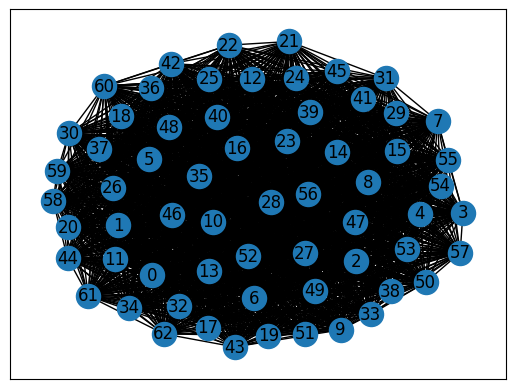

In [93]:
nx.draw_networkx(G, pos= nx.spring_layout(G))

In [75]:
cliques = nx.find_cliques(G)

In [124]:
for clique in cliques:
    print(clique)

[0, 1, 2, 3, 4]
[1, 5, 2, 3]
[3, 2, 16, 17]
[3, 2, 16, 5]
[3, 2, 17, 4]
[4, 42, 43]
[5, 8, 16]
[5, 8, 6, 7]
[6, 9, 7]
[7, 11, 9]
[7, 11, 12]
[7, 12, 8]
[8, 13, 16, 15]
[8, 13, 12]
[9, 10]
[11, 12, 13]
[14, 33, 35]
[14, 13, 16, 17, 15]
[18, 16, 2]
[18, 16, 13]
[18, 27, 21]
[18, 20, 2]
[18, 20, 21, 10]
[18, 20, 21, 19, 22, 24, 25, 26, 23]
[28, 45, 46]
[28, 46, 53]
[28, 30, 32, 27, 29, 31]
[28, 30, 53]
[29, 31, 27, 33]
[29, 31, 38, 33]
[31, 32, 58]
[31, 33, 34, 37, 38]
[31, 58, 34]
[33, 35, 34, 36, 37, 38]
[33, 35, 39]
[34, 56, 58, 59, 54]
[34, 56, 36]
[34, 59, 37]
[39, 41, 40, 43, 42, 44]
[39, 41, 40, 43, 19]
[39, 41, 45]
[41, 47, 45]
[44, 23, 24]
[45, 46, 50]
[45, 46, 47, 48, 49]
[46, 53, 50]
[47, 22, 23]
[48, 26, 49]
[49, 25, 26]
[50, 51, 52, 53]
[50, 51, 52, 54]
[52, 58, 54]
[54, 55, 56, 57, 58, 59, 60, 61, 62]


In [94]:
maxi_clique = max(nx.find_cliques(G), key=len)

In [95]:
len(maxi_clique)

63

In [77]:
sub = nx.Graph()
for node in maxi_clique:
    sub.add_node(node)

In [78]:
for (i,j), (mini, maxi) in dico_interval.items():
    if i in maxi_clique and j in maxi_clique:
        sub.add_edges_from([(i,j,{"mini":mini, "maxi":maxi})])

In [ ]:
list(sub.nodes)

In [79]:
len(list(sub.edges))

1953

In [80]:
def get_edm(nodes,t, graph):
    n = len(nodes)
    matrix = np.zeros((n,n))
    for k in range(n-1):
        for l in range(k+1,n):
            i = nodes[k]
            j = nodes[l]
            low = graph.get_edge_data(i,j)["mini"]
            up = graph.get_edge_data(i,j)["maxi"]
            matrix[k,l] = (1-t[k,l])*low + t[k,l]*up
            matrix[l,k] = (1-t[k,l])*low + t[k,l]*up
    return matrix

In [81]:
def get_x(EDM):
    U, S, Vh = np.linalg.svd(EDM)
    x = U[:,:3]
    return x

In [87]:
lamb = 1
tau = 0.1

def theta(x,i,j,c):
    return (lamb**2 *(c-np.sqrt(np.linalg.norm(x[3*i:3*(i+1)]-x[3*j:3*(j+1)])**2 + tau**2))**2 + tau**2)
def phi(x,i,j, low,up):
    value = lamb*(low - up) + theta(x,i,j,low) + theta(x,i,j,up)
    return value
def cost(x,dico_interval):
    cost_value = 0
    for (i,j) in dico_interval.keys():
            low, up = dico_interval[(i,j)]
            cost_value += phi(x,i,j,low,up)
    return cost_value


In [88]:
def get_n_error(X,nodes, graph):
    n = len(nodes)
    count = 0
    relative_error = []
    count_tot = 0
    for k in range(n-1):
        for l in range(k+1,n):
            i = nodes[k]
            j = nodes[l]
            count_tot += 1
            low = graph.get_edge_data(i,j)["mini"]
            up = graph.get_edge_data(i,j)["maxi"]
            dist = np.linalg.norm(X[k]-X[l])
            print(f"edge: ({i,j}")
            print(dist)
            print(f"low : {low}    up : {up}")
            print()
            if (dist>up or dist < low):
                count += 1
                relative_error.append(np.min([np.abs(dist-low)/low,np.abs(dist-up)/up]))

    return

In [89]:
def c_in_intermediate(X,nodes,graph):
    n = len(nodes)
    count = 0
    relative_error = []
    count_tot = 0
    for k in range(n-1):
        for l in range(k+1,n):
            i = nodes[k]
            j = nodes[l]
            count_tot += 1
            low = graph.get_edge_data(i,j)["mini"]
            up = graph.get_edge_data(i,j)["maxi"]
            dist = np.linalg.norm(X[k]-X[l])
            if (dist>up or dist < low):
                count += 1
                relative_error.append(np.min([np.abs(dist-low)/low,np.abs(dist-up)/up]))
    return count

In [96]:
def place_relative_atoms(clique,dico_interval, t=0.7):
    atoms = list(clique.nodes)
    n = len(atoms)
    ponderation = np.ones((n,n))*t
    D = get_edm(list(clique.nodes),ponderation,clique)
    x = get_x(D)
    print("before opti")
    res = minimize(cost,x.flatten(),args=(dico_interval),method='BFGS')
    print("after")
    X = res.x.reshape(n,3)
    dico_index_to_X = {}
    dico_X_to_index = {}
    count = 0
    for node in list(clique.nodes):
        dico_index_to_X[node] = count
        count += 1
    count = 0
    for node in list(clique.nodes):
        dico_X_to_index[count] = node
    count += 1 
    return X, dico_X_to_index, dico_index_to_X

In [99]:
X, dico_X_to_index, dico_index_to_X = place_relative_atoms(G,dico_interval_origin)

before opti


In [90]:
X

array([[-0.5086419 , -0.04529048, -1.89655235],
       [-0.50091488,  2.0554787 ,  0.15775394],
       [-0.49707916, -2.0204531 ,  0.16403237],
       [-0.4921365 ,  0.00635664,  1.61221973]])

In [51]:
c_in_intermediate(X, list(sub.nodes),sub)

0

In [20]:
def best_node(nodes_base,node_to_choose, graph):
    counter = [[] for _ in range(len(node_to_choose))]
    for (i,j) in graph.edges:
        if ((i in nodes_base) and (j not in nodes_base)):
            counter[j].append(i)
        if ((j in nodes_base) and (i not in nodes_base)):
            counter[i].append(j)
    for i in range(len(counter)):
        if (len(counter[i])>=3):
            return i, counter[i]


In [21]:
node, node_base_connected = best_node(list(sub.nodes), list(G.nodes), G)

In [22]:
X

array([[ 0.92379823, -3.5731522 , -0.09978916],
       [ 1.02014942, -1.09452151,  0.45208743],
       [ 0.5266358 , -1.48538446, -1.18061632],
       [-0.94895303, -2.13476559,  1.38241174],
       [-1.2133437 ,  0.10901311, -1.18948256],
       [ 0.4240286 ,  1.58868486,  0.84494465],
       [-1.3290413 ,  2.28799029, -1.21421349],
       [-1.01081181,  4.10579787,  0.04746002],
       [-1.35792877,  0.11808317,  0.55467378]])

## Compute 10th atom

In [24]:
def get_f_ctc(node_base_connected, node_to_solve, graph):
    li_ctc = []
    li_constrains = []
    li_f = []
    for atom in node_base_connected:
        low = graph.get_edge_data(node_to_solve,atom)["mini"]
        up = graph.get_edge_data(node_to_solve,atom)["maxi"]
        li_constrains.append([low,up])
        center = X[dico_index_to_X[atom]]
        f = Function("x[3]", f"sqrt(sqr(x[0]-{center[0]})+sqr(x[1]-{center[1]})+sqr(x[2]-{center[2]}))")
        li_f.append(f)
        contractor = CtcFunction(f, Interval(low,up))
        li_ctc.append(contractor)
    return li_ctc,li_f, li_constrains


In [25]:
li_ctc, li_f, li_constrains = get_f_ctc(node_base_connected, node, G)

In [26]:
def contract(x,li_ctc):
    for ctc in li_ctc:
        ctc.contract(x)
    

In [27]:
def empty(X):
    for i in range(3):
        if X[i].is_empty():
            return True
    return False

In [28]:
def C_in(X, li_f, li_constrains):
    if (empty(X)):
        return False
    for i in range(len(li_f)):
        eval = li_f[i].eval(X)
        low, up = li_constrains[i]
        if ((eval.lb() < low) or (eval.ub()>up)):
            #in_it = False
            return False
    return True

In [29]:
def C_out(X,li_f, li_constrains):
    out_it = False
    for i in range(len(li_f)):
        eval = li_f[i].eval(X)
        low, up = li_constrains[i]
        if ((eval.lb()> up) or (eval.ub() < low)):
            print(i)
            out_it = True
    return out_it

In [30]:
def get_largest(X):
    max_index = 0
    for i in range(3):
        if (X[max_index].diam() < X[i].diam()):
            max_index = i
    return max_index

In [31]:
tau = 0.000001
stack = [IntervalVector([[-10,10] for _ in range(3)])]
stack_acc = []
stack_rej = []
stack_unc = []
sol = False
count = 0
while len(stack) !=0 and (not sol):
    x = stack.pop()
    count +=1
    contract(x, li_ctc)
    if not empty(x):
        if (C_in(x,li_f, li_constrains)):
            sol = True
            print("sol")
            stack_acc.append(x)
        else:
            if C_out(x, li_f, li_constrains):
                stack_rej.append(x)
            else:
                larger_index = get_largest(x)
                if x[larger_index].diam() > tau:
                    X_left, X_right  = x.bisect(larger_index)
                    if not (empty(X_left)):
                        stack.append(X_left)
                    if not (empty(X_right)):
                        stack.append(X_right)
                else:
                    stack_unc.append(x)

0
0
0
0
0
sol


In [40]:
def mean(vector):
    vec = []
    for i in range(3):
        vec.append((vector[i][0]+vector[i][1])/2)
    return np.array(vec).reshape(1,3)


In [42]:
X_10 = mean(stack_acc[0])

In [43]:
X_10

array([[ 2.80121905, -1.68063212, -2.12347416]])

In [47]:
X = np.concatenate([X,X_10])

In [48]:
dico_index_to_X[10] = 10
dico_X_to_index[10] = 10

In [49]:
nodes_base = list(sub.nodes)
nodes_base.append(10)

In [50]:
node, node_base_connected = best_node(nodes_base, list(G.nodes), G)

TypeError: cannot unpack non-iterable NoneType object

In [52]:
counter = [[] for _ in range(63)]
for (i,j) in G.edges:
    if ((i in nodes_base) and (j not in nodes_base)):
        counter[j].append(i)
    if ((j in nodes_base) and (i not in nodes_base)):
        counter[i].append(j)


In [ ]:
counter

In [34]:
count = 0
for node_base in node_base_connected:
    bounds = li_f[count].eval(stack_acc[0])
    print(f"Low : {bounds.lb()}    Up : {bounds.ub()}")
    print(f"Needed low : {G.get_edge_data(node,node_base)['mini']}    Needed Up : {G.get_edge_data(node,node_base)['maxi']}")
    print()
    count +=1

Low : 3.3468848592262983    Up : 3.346886033314764
Needed low : 3.280604499173894    Needed Up : 3.346886033315147

Low : 3.185788515607867    Up : 3.185789688563983
Needed low : 3.185788056352778    Needed Up : 3.250153913278571

Low : 2.469985694327776    Up : 2.469986587840734
Needed low : 2.469650991537058    Needed Up : 2.519547971363112



## N cliques

In [26]:
G_prime = G.copy()

In [56]:
for noeud in list(sub.nodes):
    G_prime.remove_node(noeud)

In [65]:
cliques = nx.find_cliques(G)

In [ ]:
def already_seen(clique, cliques_tested):
    for i in range(len(cliques_tested)):
        if cliques_tested[i] in clique:

In [67]:
cliques = nx.find_cliques(G)
X_tot = []
li_index_to_X_tot = []
li_X_to_index_tot = []
errors = []
cliques_testes = []
for clique in cliques:
    if (len(clique)>3):
        sub = nx.Graph()
        for node in clique:
            sub.add_node(node)
        for (i,j), (mini, maxi) in dico_interval.items():
            if i in clique and j in clique:
                sub.add_edges_from([(i,j,{"mini":mini, "maxi":maxi})])
        X, dico_X_to_index, dico_index_to_X = place_relative_atoms(sub)
        errors.append(c_in_intermediate(X,list(sub.nodes),sub))
        X_tot.append(X)
        li_index_to_X_tot.append(dico_index_to_X)
        li_X_to_index_tot.append(dico_X_to_index)
        errors.append(c_in_intermediate(X,list(sub.nodes),sub))
    

In [69]:
def post_treatment(X_tot, li_X_to_index_tot, li_index_to_X_tot):
    n = len(X_tot)
    cliques_seen = []

True

In [62]:
maxi_clique = max(nx.find_cliques(G_prime), key=len)

In [63]:
maxi_clique

[54, 58, 56, 59, 55, 57, 60, 61, 62]

# Construction

In [ ]:
dico_constrains

In [65]:
def get_f_ctc(X, dico_interval, atom):
    li_ctc = []
    li_constrains = []
    li_f = []
    for ((i,j), (low,up)) in dico_interval.items():
        if j == atom:
            #low1 = low*0.6+0.4*up
            #up = low*0.4+0.6*up
            #low = low1
            li_constrains.append([low,up])

            center = X[i]
            f = Function("x[3]", f"sqrt(sqr(x[0]-{center[0]})+sqr(x[1]-{center[1]})+sqr(x[2]-{center[2]}))")
            li_f.append(f)
            contractor = CtcFunction(f, Interval(low,up))
            li_ctc.append(contractor)
    
    return li_ctc, li_f, li_constrains

def contract(x,li_ctc):
    for ctc in li_ctc:
        ctc.contract(x)
    
def empty(X):
    for i in range(3):
        if X[i].is_empty():
            return True
    return False
def C_in(X, li_f, li_constrains):
    if (empty(X)):
        return False
    for i in range(len(li_f)):
        eval = li_f[i].eval(X)
        low, up = li_constrains[i]
        if ((eval.lb() < low) or (eval.ub()>up)):
            #in_it = False
            return False
    return True
def C_out(X,li_f, li_constrains):
    out_it = False
    for i in range(len(li_f)):
        eval = li_f[i].eval(X)
        low, up = li_constrains[i]
        if ((eval.lb()> up) or (eval.ub() < low)):
            out_it = True
    return out_it
def get_largest(X):
    max_index = 0
    for i in range(3):
        if (X[max_index].diam() < X[i].diam()):
            max_index = i
    if (X[0].diam() == X[1].diam() and X[1].diam() == X[2].diam()):
        return np.random.randint(3)
    return max_index
def mean(vector):
    vec = []
    for i in range(3):
        vec.append((vector[i][0]+vector[i][1])/2)
    return np.array(vec).reshape(1,3)


In [66]:
def add_atom(X, dico_interval, atom):
    tau = 0.0000000001
    stack = [IntervalVector([[-20,20] for _ in range(3)])]
    li_ctc, li_f, li_constrains = get_f_ctc(X, dico_interval, atom)
    print(len(li_ctc))
    stack_acc = []
    stack_rej = []
    stack_unc = []
    sol = 0
    count = 0
    while len(stack) !=0 and (not sol):
        x = stack.pop()
        count +=1
        contract(x, li_ctc)
        if not empty(x):
            if (C_in(x,li_f, li_constrains)):
                sol = True
                stack_acc.append(x)
            else:
                if C_out(x, li_f, li_constrains):
                    stack_rej.append(x)
                else:
                    larger_index = get_largest(x)
                    if x[larger_index].diam() > tau:
                        X_left, X_right  = x.bisect(larger_index)
                        if not (empty(X_left)):
                            stack.append(X_left)
                        if not (empty(X_right)):
                            stack.append(X_right)
                    else:
                        stack_unc.append(x)
    if (len(stack_acc) != 0):
        pos = mean(stack_acc[0])
    new_X = np.concatenate([X,pos])
    return new_X
    

In [67]:
def replace_atom(X, dico_interval, atom):
    tau = 0.0000000001
    stack = [IntervalVector([[-20,20] for _ in range(3)])]
    li_ctc, li_f, li_constrains = get_f_ctc(X, dico_interval, atom)
    print(len(li_ctc))
    stack_acc = []
    stack_rej = []
    stack_unc = []
    sol = 0
    count = 0
    while len(stack) !=0 and (not sol):
        x = stack.pop()
        count +=1
        contract(x, li_ctc)
        if not empty(x):
            if (C_in(x,li_f, li_constrains)):
                #sol = True
                stack_acc.append(x)
            else:
                if C_out(x, li_f, li_constrains):
                    stack_rej.append(x)
                else:
                    larger_index = get_largest(x)
                    if x[larger_index].diam() > tau:
                        X_left, X_right  = x.bisect(larger_index)
                        if not (empty(X_left)):
                            stack.append(X_left)
                        if not (empty(X_right)):
                            stack.append(X_right)
                    else:
                        stack_unc.append(x)
    if (len(stack_acc) != 0):
        pos = mean(stack_acc[0])
    print(count)
    X[atom] = pos
    return X

In [68]:
X

NameError: name 'X' is not defined

In [72]:
#X = np.random.normal(loc = 0, scale=20, size=(63,3))
X = np.zeros((,3))
X[1] = [dico_constrains[(0,1)],0,0]
X[2] = [0,dico_constrains[(0,2)],0]
#X[3] = [0,0,dico_constrains[(0,3)]]



In [73]:
X

array([[0.        , 0.        , 0.        ],
       [2.71784866, 0.        , 0.        ],
       [0.        , 4.49537026, 0.        ]])

In [73]:
count = 1
X = np.zeros((1,3))
while count!=15:
    print(count)
    X = add_atom(X, dico_interval, count)
    count += 1

1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12


UnboundLocalError: local variable 'pos' referenced before assignment

In [74]:
X

array([[ 0.        ,  0.        ,  0.        ],
       [ 1.58518573,  1.58458354,  1.58458352],
       [ 2.10092256,  0.1189951 ,  4.02305863],
       [ 3.24807154,  0.30553505,  2.73424025],
       [ 4.77997505, -1.47767691,  2.86251755],
       [ 1.345242  ,  2.93805463,  3.36492321],
       [ 3.01030455,  4.60311719,  5.03061855],
       [ 3.82467668,  5.41996581,  2.84905433],
       [ 2.91548452,  3.93514199,  1.05076797],
       [ 4.7031667 ,  6.30293313,  5.27844718],
       [ 5.50888305,  4.36180541,  7.17299593],
       [ 5.79810737,  7.3933965 ,  3.21810429]])

In [92]:
X_5_8 = np.array([[-0.5086419 , -0.04529048, -1.89655235],
       [-0.50091488,  2.0554787 ,  0.15775394],
       [-0.49707916, -2.0204531 ,  0.16403237],
       [-0.4921365 ,  0.00635664,  1.61221973]])

In [ ]:
X_tot = np.concatenate([X,X_5_8])

In [78]:
count = 5
X = np.zeros((5,3))
while count!=9:
    print(count)
    X = add_atom(X, dico_interval, count)
    count += 1

5
3


UnboundLocalError: local variable 'pos' referenced before assignment

In [67]:
np.linalg.norm(X[1])

2.7205665736483455

In [11]:
def verif(X,dico_interval):
    n = X.shape[0]
    count = 0
    for (i,j), (low,up) in dico_interval.items():
        if i<n and j<n:
            dist = np.linalg.norm(X[i] - X[j])
            print(f"edge: ({i,j}")
            print(dist)
            print(f"low : {low}    up : {up}")
            print()
    return count

In [15]:
def verif_tot(X, dico_interval):
    for (i,j), (low,up) in dico_interval.items():
        dist = np.linalg.norm(X[i] - X[j])
        if dist<low or dist >up:
            return False
    return True

In [12]:
verif(X,dico_interval)

edge: ((0, 1)
2.720566573648345
low : 2.704259074127328    up : 2.73143824019508

edge: ((0, 2)
4.499865741632193
low : 4.472892845799014    up : 4.51784767228821

edge: ((0, 3)
4.218910981032833
low : 4.193622171822353    up : 4.235770187344921

edge: ((0, 4)
5.713018433776803
low : 5.678773711814897    up : 5.735848248515641

edge: ((1, 2)
2.9177804646890046
low : 2.906097367604874    up : 2.935305110205748

edge: ((1, 3)
2.4140916571547386
low : 2.404425382497866    up : 2.42859106891218

edge: ((1, 4)
4.603847138674955
low : 4.585412854912853    up : 4.631498564179853

edge: ((1, 5)
2.229275599337962
low : 2.215912974374222    up : 2.23818401611664

edge: ((2, 3)
1.7509503928668855
low : 1.743909289498742    up : 1.761436456418456

edge: ((2, 4)
3.3630527861748156
low : 3.344627737133087    up : 3.378242930873976

edge: ((2, 5)
2.9953013563036586
low : 2.977350238047247    up : 3.007274107892395

edge: ((3, 4)
2.3372031934710327
low : 2.327657584353851    up : 2.351051715722138

ed

0

In [128]:
np.linalg.norm(X[0] - X[1])

2.7161861812419787

In [84]:
X0 = np.array([2.83455656e+00 ,  6.36186041e-01 ,  3.63035087e+00 ])
X1 = np.array([6.89690506e-01 , -4.68265409e-01 ,  2.38392374e+00])
np.linalg.norm(X0 - X1)

2.7154822749207317

In [129]:
X 

array([[ 0.55787626,  3.02003749,  0.19846142],
       [-1.30423651,  1.31719859, -0.8067963 ],
       [-1.6210181 , -0.78209289,  1.19615428],
       [-0.71340402, -0.96693982, -0.28869732],
       [ 0.86540609, -2.67338861, -0.04022001],
       [-0.51897231,  2.01584711,  1.16923965],
       [ 1.13853775,  3.6727275 ,  2.82612003],
       [-1.06257858,  4.48145958,  3.6341082 ],
       [-2.85191609,  2.94703924,  2.72455013],
       [ 1.35081799,  5.36385337,  4.51567046],
       [ 2.97623767,  6.98989076,  6.14109012],
       [-0.73378358,  6.44859615,  5.60124475]])

In [87]:
X + np.array(X0)

array([[2.83455656, 0.63618604, 3.63035087],
       [4.4113534 , 2.21298286, 5.20774694],
       [2.95296691, 4.69363621, 5.61378847],
       [3.08799176, 3.42792869, 6.80583393],
       [1.32855709, 3.57049243, 8.3230864 ],
       [5.78924311, 3.95617846, 4.93912691],
       [7.44675317, 5.61305887, 6.59600727],
       [5.24563684, 6.42179094, 7.40399546],
       [3.45629934, 4.8873706 , 6.49443739],
       [7.65903342, 7.30418474, 8.2855577 ],
       [9.28445307, 8.92960443, 9.91159509],
       [5.57443185, 8.3889275 , 9.371132  ]])

In [134]:
X8 = np.array([  7.06760517e-01,  -4.71016652e+00 , -1.34681783e+00])
X9 = np.array([ -1.49827588e+00 , -4.08228545e+00,  -3.37522343e-01])
X12 = np.array([ -1.04372973e+00 , -3.02951353e+00 ,  3.31519175e-02])
X13 = np.array([  5.43530260e-01 , -1.51619354e+00 , -3.06569111e-01])
print(np.linalg.norm(X8-X13))
print(np.linalg.norm(X9-X13))
print(np.linalg.norm(X12-X13))

      


3.363067782717367
3.2794447863137433
2.2192210446896676


In [27]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

IndexError: list index out of range

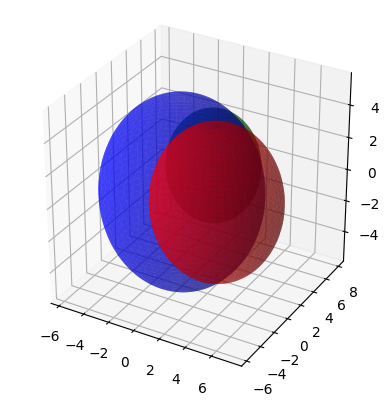

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect("equal")
color = ["b","r","g"]
count = 0
for i in [0,1,2,3]:
    center = X[i]
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    radius = np.mean(dico_interval[(i,4)])
    x = center[0] + radius * np.outer(np.cos(u), np.sin(v))
    y = center[1] + radius * np.outer(np.sin(u), np.sin(v))
    z = center[2] + radius * np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_surface(x, y, z, color=color[count], alpha=0.5)
    count += 1
plt.show()

In [63]:
for (i,j),(low,up) in dico_interval.items():
    if j==12:
        print(i)

7
8
11
